In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt

from libs.findpeaks import findpeaks # janko_slavic
from libs import detect_peaks # detect_peaks tony berta

### cwt_find_peaks

In [2]:
class QRSDetector():
    """QRS complex detector."""

    def __init__(self, file):
        """Variables initialization."""
        ## Data file path.
        self.file = file
        
        ## Signal processing variables.
        self.logged_beats = np.array([])
        self.raw_signal = np.array([])
        self.filtered = np.array([])
        self.differentiated_signal = np.array([])
        self.squared_signal = np.array([])
        self.integrated_signal = np.array([])

        # Peak detection variables.
        self.fiducial_mark_val_i = np.array([])
        self.fiducial_mark_idx = np.array([])

        ## Peak thresholding variables.
        self.qrs_peak_i = np.array([])
        self.noise_peak_i = np.array([])
        
        ## Integrated signal detection and thresholding params.
        self.spk_i = 0.0 
        self.npk_i = 0.0 
        self.threshold_i_1 = 0.0
        self.threshold_i_2 = 0.0 

        ## Params.
        self.signal_freq = 255
        self.integration_window = 35
        self.peak_width_low = 10
        self.peak_width_high = 15
        
    ## Tool methods.
    def butter_bandpass_filter(self, data, lowcut, highcut, signal_freq, order):
        """Constructs signal filter."""
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(order, [low, high], btype='band')
        y = lfilter(b, a, data)
        return y
    
    ## Data processing methods.
    def load_data(self):
        """Loads and cleans data."""
        with open(self.file) as f:
            content = f.readlines()
        content = content[1:]
        for line in content:
            log = line.rstrip().split(' ')
            self.raw_signal = np.append(self.raw_signal, float(line.rstrip().split(' ')[2]))
            self.logged_beats = np.append(self.logged_beats, float(line.rstrip().split(' ')[3]))
    
    def process_data(self):
        """Process received data."""
        ## Signal filtering - pass band 0-15 Hz.
        self.filtered_signal = self.butter_bandpass_filter(self.raw_signal, lowcut=0.0, 
                                                           highcut=15.0, signal_freq=self.signal_freq, order=1)
        
        ## Derivative - provides QRS slope info.
        self.differentiated_signal = np.ediff1d(self.filtered_signal) 

        ## Squaring.
        self.squared_signal = self.differentiated_signal**2
        
        ## Moving-window integration.
        self.integrated_signal = np.convolve(self.squared_signal, np.ones(self.integration_window))

        ## Fiducial mark - peak detection - integrated signal
        self.peaks_indices = find_peaks_cwt(self.integrated_signal, 
                                            np.arange(self.peak_width_low, self.peak_width_high), noise_perc=0.1)

        for peak_index in self.peaks_indices:
            self.fiducial_mark_idx = np.append(self.fiducial_mark_idx, peak_index)
            self.fiducial_mark_val_i = np.append(self.fiducial_mark_val_i, self.integrated_signal[peak_index])
    
    def threshold_peaks(self):
        """Thresholding detect peaks - integrated signal."""
        for peak_idx, peak_val_i in zip(self.fiducial_mark_idx, self.fiducial_mark_val_i):
            if peak_val_i > self.threshold_i_1:
                self.spk_i = 0.125 * peak_val_i + 0.875 * self.spk_i
                self.qrs_peak_i = np.append(self.qrs_peak_i, peak_idx)
            else:
                self.npk_i = 0.125 * peak_val_i + 0.875 * self.npk_i
                self.noise_peak_i = np.append(self.noise_peak_i, peak_idx)

            self.threshold_i_1 = self.npk_i + 0.25 * (self.spk_i - self.npk_i)
            self.threshold_i_2 = 0.5 * self.threshold_i_1 
        
    ## Visualization methods.
    def plot_everything(self):
        ## Plot everything.
        plt.figure(figsize=(15,18))
        plt.subplot(711)
        plt.plot(self.raw_signal, label="Original signal", color="salmon")
        plt.plot(self.logged_beats, label="Original signal", color="grey")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(712)
        plt.plot(self.filtered_signal, label="Filtered signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(713)
        plt.plot(self.differentiated_signal, label="Differentiated signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(714)
        plt.plot(self.squared_signal, label="Squared signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        fiducial_mark_indication_i = [0] * len(self.integrated_signal)
        for peak_idx_i, peak_val_i in zip(self.fiducial_mark_idx, self.fiducial_mark_val_i):
            fiducial_mark_indication_i[int(peak_idx_i)] = peak_val_i
        plt.subplot(715)
        plt.plot(self.integrated_signal, label="Integrated signal", color="salmon")
        plt.plot(fiducial_mark_indication_i, 'k.')
        plt.plot(self.logged_beats / 3.0, label="Original signal", color="grey")
        plt.grid(True)
        plt.axis("tight")
        
        qrs_peak_indication_i = [0] * len(self.integrated_signal)
        for peak_i in self.qrs_peak_i:
            qrs_peak_indication_i[int(peak_i)] = self.raw_signal[int(peak_i)]
        noise_peak_indication_i = [0] * len(self.integrated_signal)
        for peak_i in self.noise_peak_i:
            noise_peak_indication_i[int(peak_i)] = self.raw_signal[int(peak_i)]
            
        plt.subplot(716)
        plt.plot(self.raw_signal, label="Integrated signal", color="salmon")
        plt.plot(qrs_peak_indication_i, 'k.')
        plt.plot(noise_peak_indication_i, 'yo')
        plt.plot(self.logged_beats, label="Original signal", color="grey")
        plt.grid(True)
        plt.axis("tight")
        
        plt.subplot(717)
        plt.plot(self.raw_signal, 'k.', label="Integrated signal", color="salmon")
        plt.plot(qrs_peak_indication_i, 'k.')
        plt.plot(noise_peak_indication_i, 'yo')
        plt.grid(True)
        plt.axis("tight")

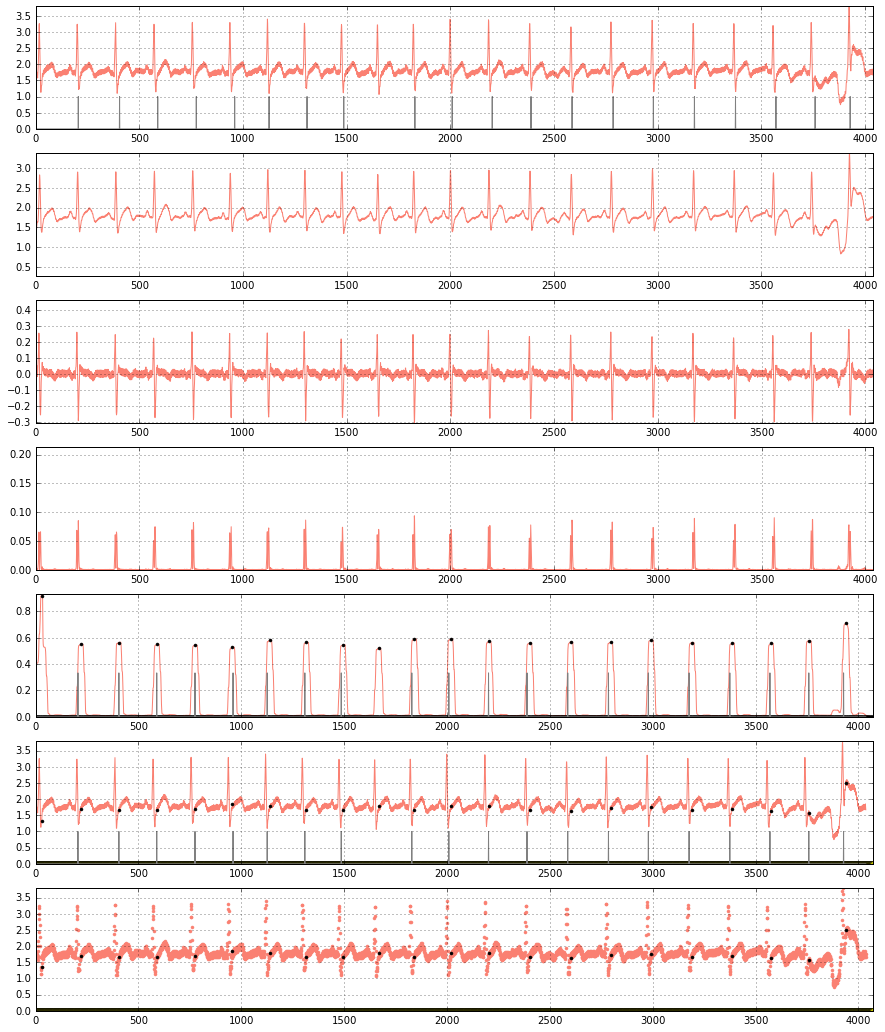

In [3]:
qrs_detector = QRSDetector("logs250hz/20.txt")
qrs_detector.load_data()
qrs_detector.process_data()
qrs_detector.threshold_peaks()
qrs_detector.plot_everything()

### janko slavic

In [4]:
class QRSDetector():
    """QRS complex detector."""

    def __init__(self, file):
        """Variables initialization."""
        ## Data file path.
        self.file = file
        
        ## Signal processing variables.
        self.logged_beats = np.array([])
        self.raw_signal = np.array([])
        self.filtered = np.array([])
        self.differentiated_signal = np.array([])
        self.squared_signal = np.array([])
        self.integrated_signal = np.array([])

        # Peak detection variables.
        self.fiducial_mark_val_i = np.array([])
        self.fiducial_mark_idx = np.array([])

        ## Peak thresholding variables.
        self.qrs_peak_i = np.array([])
        self.noise_peak_i = np.array([])
        
        ## Integrated signal detection and thresholding params.
        self.spk_i = 0.0 
        self.npk_i = 0.0 
        self.threshold_i_1 = 0.0
        self.threshold_i_2 = 0.0 

        ## Params.
        self.signal_freq = 255
        self.filter_lowcut = 0.0
        self.filter_highcut = 15.0
        self.integration_window = 15
        
    ## Tool methods.
    def butter_bandpass_filter(self, data, lowcut, highcut, signal_freq, order):
        """Constructs signal filter."""
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(order, [low, high], btype='band')
        y = lfilter(b, a, data)
        return y
    
    ## Data processing methods.
    def load_data(self):
        """Loads and cleans data."""
        with open(self.file) as f:
            content = f.readlines()
        content = content[1:]
        for line in content:
            log = line.rstrip().split(' ')
            self.raw_signal = np.append(self.raw_signal, float(line.rstrip().split(' ')[2]))
#             self.logged_beats = np.append(self.logged_beats, float(line.rstrip().split(' ')[3]))
        self.raw_signal = [1.7546432018, 1.6471162796, 1.5542521476, 1.6617790222, 1.8035190582, 1.8768328666, 1.7693059444, 1.666666603, 1.7497556209, 1.901270771, 1.989247322, 1.8914956092, 1.7497556209, 1.7888562679, 1.9403715133, 2.0234603881, 1.9648094177, 1.8132943153, 1.8328446388, 1.9745845794, 2.0918865203, 2.0576734542, 1.8963831901, 1.8719452857, 1.9843597412, 2.106549263, 2.0821113586, 1.9110459327, 1.8475073814, 1.9599218368, 2.0967741012, 2.1212120056, 1.9745845794, 1.8768328666, 1.9648094177, 2.0918865203, 2.1358749866, 2.0039100646, 1.8817204475, 1.9550342559, 2.0869989395, 2.1505377292, 2.0381231307, 1.8914956092, 1.9208210945, 2.0478982925, 2.1260998249, 2.028347969, 1.8475073814, 1.8279570579, 1.9208210945, 1.989247322, 1.901270771, 1.7008798122, 1.6226783752, 1.7008798122, 1.7790811061, 1.7302052974, 1.5493645668, 1.4662756919, 1.5591397285, 1.666666603, 1.6813293457, 1.5298142433, 1.4369501113, 1.5249266624, 1.6568914413, 1.7106549739, 1.59335289, 1.4907135963, 1.5689149856, 1.7057673931, 1.7790811061, 1.6813293457, 1.5493645668, 1.5982404708, 1.7350928783, 1.8181818962, 1.7497556209, 1.6080156326, 1.6324535369, 1.7644183635, 1.8670577049, 1.8181818962, 1.6568914413, 1.6422286987, 1.7693059444, 1.8866080284, 1.8719452857, 1.7253177165, 1.6813293457, 1.8035190582, 1.9257086753, 1.9305962562, 1.7790811061, 1.6911046504, 1.783968687, 1.9159335136, 1.9501466751, 1.8181818962, 1.7106549739, 1.7888562679, 1.9159335136, 1.9745845794, 1.8523949623, 1.7204301357, 1.7741935253, 1.9159335136, 1.9941349029, 1.901270771, 1.7546432018, 1.783968687, 1.9208210945, 2.0234603881, 1.9648094177, 1.8035190582, 1.8132943153, 1.9257086753, 2.0332355499, 1.9941349029, 1.823069477, 1.7741935253, 1.8866080284, 2.0039100646, 2.0039100646, 1.8475073814, 1.7693059444, 1.8670577049, 1.9941349029, 2.0136852264, 1.8719452857, 1.7693059444, 1.8572825431, 1.9990224838, 2.0576734542, 1.9452590942, 1.8132943153, 1.8768328666, 2.0185728073, 2.106549263, 2.0136852264, 1.8719452857, 1.8914956092, 2.028347969, 2.1260998249, 2.067448616, 1.9159335136, 1.9110459327, 2.0430107116, 2.1407625675, 2.0967741012, 1.9257086753, 1.8719452857, 1.9794721603, 2.0772237777, 2.0527858734, 1.8670577049, 1.7741935253, 1.8377322196, 1.9501466751, 1.9452590942, 1.783968687, 1.6715541839, 1.7497556209, 1.8768328666, 1.9305962562, 1.8035190582, 1.666666603, 1.7253177165, 1.8426198005, 1.9159335136, 1.808406639, 1.666666603, 1.7057673931, 1.8475073814, 1.9354838371, 1.8523949623, 1.6764417648, 1.6715541839, 1.8328446388, 2.0136852264, 2.1212120056, 2.1896383762, 2.4535679817, 2.9081134796, 3.3528835773, 3.4848484992, 3.2160313129, 2.8739002227, 2.5708699226, 2.2434017658, 1.8817204475, 1.4565005302, 1.1681329011, 1.1534701585, 1.2756597995, 1.3734115362, 1.3489736318, 1.3147605657, 1.4565005302] 
        
    def process_data(self):
        """Process received data."""
        ## Signal filtering - pass band 0-15 Hz.
#         self.filtered_signal = self.butter_bandpass_filter(self.raw_signal, lowcut=self.filter_lowcut, 
#                                                            highcut=self.filter_highcut, signal_freq=self.signal_freq, order=1)
        self.filtered_signal = [0.27634233, 0.72504892, 1.00086008, 1.19210439, 1.36236734, 1.51286945, 1.61057749, 1.64440955, 1.66450602, 1.71522072, 1.78767913, 1.83577478, 1.83100303, 1.81156943, 1.82827759, 1.87667123, 1.91367041, 1.90591596,1.87982064, 1.88734686, 1.93329947, 1.97786358, 1.97760049, 1.94816956,1.94186451, 1.97449371, 2.01224033, 2.00730715, 1.96697958, 1.94705212,1.97265902, 2.01560207, 2.02577486, 1.99425562, 1.97112493, 1.98914928,2.0284377, 2.04149531, 2.01041267, 1.98142301, 1.99389436, 2.03322767,2.05247407, 2.02486108, 1.98747161, 1.98649141, 2.01814972, 2.03675714,2.00562744, 1.95274312, 1.92806284, 1.93655839, 1.93929896, 1.89576071,1.82206023, 1.77157422, 1.76162269, 1.75942426, 1.72173978, 1.6543585,1.60974076, 1.61073687, 1.63066311, 1.62275974, 1.57885803, 1.5480149,1.56152588, 1.60003184, 1.61640222, 1.59297718, 1.57308187, 1.59332253,1.6402872, 1.66860995, 1.65183295, 1.62725461, 1.63966878, 1.68281171,1.71467457, 1.70340162, 1.67720533, 1.68389264, 1.72542184, 1.76233733,1.75452552, 1.72146307, 1.71651916, 1.7516203, 1.79183002, 1.79397238,1.76541944, 1.7581763, 1.79170244, 1.83468202, 1.84103105, 1.80766221,1.78557378, 1.80585161, 1.84591396, 1.8579622, 1.82849741, 1.803695,1.81903469, 1.85879335, 1.87602185, 1.84779635, 1.81614533, 1.8252541,1.86613276, 1.89182604, 1.8717083, 1.83945319, 1.84352962, 1.88404007,1.91871819, 1.90783425, 1.87651615, 1.87430665, 1.90743209, 1.94090014,1.9307268, 1.88911888, 1.87062362, 1.89413259, 1.92871074, 1.92776515,1.89016913, 1.86749428, 1.88737041, 1.92407854, 1.92998031, 1.89553532,1.86963069, 1.88806413, 1.93225131, 1.95405292, 1.9304996, 1.90358862,1.9174839, 1.96318088, 1.99371429, 1.97768191, 1.94745558, 1.95138223,1.99102035, 2.02433114, 2.01405003, 1.98237514, 1.98069098, 2.01571584,2.04817573, 2.036542, 1.99316396, 1.97191664, 1.98969161, 2.01341407,1.99656486, 1.9411468 , 1.89856602, 1.89710872, 1.91304508, 1.89779002,1.84423373, 1.80215853, 1.8056661, 1.8365498, 1.84615929, 1.81117513,1.77489433, 1.77775263, 1.80973108, 1.82624853, 1.79830569, 1.76299954,1.76729524, 1.80641638, 1.83398474, 1.81207244, 1.76858118, 1.76342118,1.81376942, 1.89367432, 1.97612168, 2.08494285, 2.27264119, 2.54285258,2.81878286, 2.98624636, 3.00474204, 2.91580409, 2.7555817, 2.53729125,2.26382815, 1.9641172, 1.71108557, 1.55468949, 1.4821947, 1.44408096,1.40873538, 1.40145773]
        ## Derivative - provides QRS slope info.
#         self.differentiated_signal = np.ediff1d(self.filtered_signal) 
        self.differentiated_signal = np.array([1.0000000e+00, 6.14680450e-01, 4.26212394e-01, 3.79452756e-01, 3.35413176e-01,  2.17754870e-01,  7.53990604e-02,  4.47875675e-02, 1.13024180e-01,  1.61482827e-01,  1.07187314e-01, -1.06344452e-02,-4.33102630e-02,  3.72362677e-02,  1.07851402e-01,  8.24574167e-02,-1.72817836e-02, -5.81567643e-02,  1.67731423e-02,  1.02411273e-01, 9.93168119e-02, -5.86336689e-04, -6.55905901e-02, -1.40516100e-02, 7.27183389e-02,  8.41231716e-02, -1.09942224e-02, -8.98751331e-02,-4.44108892e-02,  5.70682415e-02,  9.57040737e-02,  2.26713767e-02,-7.02446565e-02, -5.15497039e-02,  4.01695569e-02,  8.75592842e-02, 2.91005489e-02, -6.92716498e-02, -6.46071592e-02,  2.77939969e-02, 8.76593162e-02,  4.28930527e-02, -6.15390625e-02, -8.33272128e-02,-2.18451347e-03,  7.05545875e-02,  4.14690264e-02, -6.93765334e-02,-1.17859464e-01, -5.50031471e-02,  1.89334203e-02,  6.10770437e-03,-9.70305640e-02, -1.64250943e-01, -1.12514513e-01, -2.21782622e-02,-4.89947773e-03, -8.39846885e-02, -1.50167801e-01, -9.94363410e-02, 2.21995489e-03,  4.44081766e-02, -1.76136562e-02, -9.78405793e-02,-6.87378532e-02,  3.01109318e-02,  8.58154584e-02,  3.64834882e-02,-5.22057025e-02, -4.43392257e-02,  4.51088996e-02,  1.04666760e-01, 6.31208600e-02, -3.73896735e-02, -5.47759803e-02,  2.76665711e-02, 9.61495319e-02,  7.10104539e-02, -2.51232025e-02, -5.83817853e-02, 1.49035185e-02,  9.25531302e-02,  8.22708920e-02, -1.74096230e-02,-7.36838812e-02, -1.10181388e-02,  7.82273770e-02,  8.96124982e-02, 4.77451983e-03, -6.36338824e-02, -1.61422459e-02,  7.47172820e-02, 9.57854982e-02,  1.41496159e-02, -7.43667176e-02, -4.92268888e-02, 4.51917341e-02,  8.92840581e-02,  2.68510514e-02, -6.56660653e-02,-5.52753365e-02,  3.41864609e-02,  8.86072608e-02,  3.83959173e-02,-6.29041409e-02, -7.05383496e-02,  2.03000586e-02,  9.11033367e-02, 5.72607445e-02, -4.48349410e-02, -7.18846402e-02,  9.08484287e-03, 9.02827254e-02,  7.72846167e-02, -2.42562626e-02, -6.97963837e-02,-4.92416281e-03,  7.38242930e-02,  7.45878160e-02, -2.26725856e-02,-9.27285555e-02, -4.12190698e-02,  5.23927487e-02,  7.70618421e-02,-2.10736524e-03, -8.37875445e-02, -5.05338128e-02,  4.42965038e-02, 8.18087707e-02,  1.31528392e-02, -7.67650564e-02, -5.77317794e-02, 4.10812796e-02,  9.84767638e-02,  4.85876792e-02, -5.24915763e-02,-5.99745652e-02,  3.09673976e-02,  1.01841579e-01,  6.80476065e-02,-3.57302210e-02, -6.73632427e-02,  8.75106036e-03,  8.83386151e-02, 7.42373391e-02, -2.29127515e-02, -7.05915547e-02, -3.75337007e-03, 7.80573834e-02,  7.23410243e-02, -2.59272549e-02, -9.66735032e-02,-4.73523835e-02,  3.96137932e-02,  5.28685427e-02, -3.75506338e-02,-1.23506226e-01, -9.48967180e-02, -3.24776847e-03,  3.55162063e-02,-3.39978330e-02, -1.19357054e-01, -9.37699662e-02,  7.81707641e-03, 6.88282812e-02,  2.14159726e-02, -7.79666853e-02, -8.08563991e-02, 6.37009035e-03,  7.12680678e-02,  3.68112457e-02, -6.22741854e-02,-7.86842743e-02,  9.57352801e-03,  8.71864540e-02,  6.14396076e-02,-4.88343601e-02, -9.69258243e-02, -1.14997121e-02,  1.12207476e-01, 1.78078297e-01,  1.83744466e-01,  2.42521887e-01,  4.18309747e-01, 6.02200640e-01,  6.14945911e-01,  3.73213815e-01,  4.12199825e-02,-1.98209582e-01, -3.57076089e-01, -4.86488165e-01, -6.09447499e-01,-6.67944148e-01, -5.63913357e-01, -3.48548646e-01, -1.61563903e-01,-8.49413425e-02, -7.87721435e-02, -1.62191855e-02])
        ## Squaring.
#         self.squared_signal = self.differentiated_signal**2
        self.squared_signal = np.array([1.00000000e+00, 3.77832055e-01, 1.81657005e-01, 1.43984394e-01, 1.12501998e-01, 4.74171833e-02, 5.68501830e-03, 2.00592620e-03, 1.27744652e-02, 2.60767035e-02, 1.14891204e-02, 1.13091424e-04, 1.87577888e-03, 1.38653963e-03, 1.16319250e-02, 6.79922558e-03, 2.98660045e-04, 3.38220923e-03, 2.81338302e-04, 1.04880688e-02, 9.86382913e-03, 3.43790713e-07, 4.30212551e-03, 1.97447743e-04, 5.28795681e-03, 7.07670800e-03, 1.20872926e-04, 8.07753955e-03, 1.97232708e-03, 3.25678419e-03, 9.15926972e-03, 5.13991320e-04, 4.93431176e-03, 2.65737198e-03, 1.61359330e-03, 7.66662825e-03, 8.46841947e-04, 4.79856146e-03, 4.17408502e-03, 7.72506264e-04, 7.68415571e-03, 1.83981397e-03, 3.78705621e-03, 6.94342439e-03, 4.77209908e-06, 4.97794981e-03, 1.71968015e-03, 4.81310339e-03, 1.38908531e-02, 3.02534620e-03, 3.58474404e-04, 3.73040527e-05, 9.41493034e-03, 2.69783722e-02, 1.26595156e-02, 4.91875315e-04, 2.40048820e-05, 7.05342791e-03, 2.25503684e-02, 9.88758592e-03, 4.92819973e-06, 1.97208615e-03, 3.10240885e-04, 9.57277896e-03, 4.72489247e-03, 9.06668215e-04, 7.36429290e-03, 1.33104491e-03, 2.72543537e-03, 1.96596694e-03, 2.03481282e-03, 1.09551305e-02, 3.98424296e-03, 1.39798768e-03, 3.00040802e-03, 7.65439156e-04, 9.24473249e-03, 5.04248456e-03, 6.31175305e-04, 3.40843285e-03, 2.22114864e-04, 8.56608191e-03, 6.76849967e-03, 3.03094973e-04, 5.42931434e-03, 1.21399384e-04, 6.11952251e-03, 8.03039983e-03, 2.27960396e-05, 4.04927100e-03, 2.60572101e-04, 5.58267223e-03, 9.17486167e-03, 2.00211629e-04, 5.53040868e-03, 2.42328659e-03, 2.04229283e-03, 7.97164302e-03, 7.20978963e-04, 4.31203214e-03, 3.05536282e-03, 1.16871411e-03, 7.85124666e-03, 1.47424646e-03, 3.95693094e-03, 4.97565877e-03, 4.12092380e-04, 8.29981796e-03, 3.27879287e-03, 2.01017194e-03, 5.16740150e-03, 8.25343699e-05, 8.15097051e-03, 5.97291198e-03, 5.88366276e-04, 4.87153518e-03, 2.42473794e-05, 5.45002623e-03, 5.56334230e-03, 5.14046136e-04, 8.59858500e-03, 1.69901172e-03, 2.74500011e-03, 5.93852751e-03, 4.44098824e-06, 7.02035262e-03, 2.55366623e-03, 1.96218025e-03, 6.69267496e-03, 1.72997180e-04, 5.89287389e-03, 3.33295835e-03, 1.68767153e-03, 9.69767301e-03, 2.36076257e-03, 2.75536558e-03, 3.59694847e-03, 9.58979717e-04, 1.03717072e-02, 4.63047676e-03, 1.27664869e-03, 4.53780647e-03, 7.65810575e-05, 7.80371091e-03, 5.51118252e-03, 5.24994179e-04, 4.98316760e-03, 1.40877869e-05, 6.09295511e-03, 5.23322380e-03, 6.72222546e-04, 9.34576622e-03, 2.24224822e-03, 1.56925261e-03, 2.79508280e-03, 1.41005010e-03, 1.52537879e-02, 9.00538708e-03, 1.05480001e-05, 1.26140091e-03, 1.15585265e-03, 1.42461063e-02, 8.79280657e-03, 6.11066836e-05, 4.73733230e-03, 4.58643884e-04, 6.07880402e-03, 6.53775728e-03, 4.05780511e-05, 5.07913749e-03, 1.35506781e-03, 3.87807417e-03, 6.19121503e-03, 9.16524386e-05, 7.60147776e-03, 3.77482539e-03, 2.38479473e-03, 9.39461542e-03, 1.32243378e-04, 1.25905177e-02, 3.17118800e-02, 3.37620289e-02, 5.88168658e-02, 1.74983044e-01, 3.62645611e-01, 3.78158473e-01, 1.39288552e-01, 1.69908695e-03, 3.92870385e-02, 1.27503333e-01, 2.36670734e-01, 3.71426255e-01, 4.46149385e-01, 3.17998274e-01, 1.21486159e-01, 2.61028947e-02, 7.21503166e-03, 6.20505059e-03, 2.63061978e-04])
    
        ## Moving-window integration.
#         self.integrated_signal = np.convolve(self.squared_signal, np.ones(self.integration_window))
        self.integrated_signal = np.array([6.66666667e-02, 9.18554703e-02, 1.03965937e-01, 1.13564897e-01,1.21065030e-01, 1.24226176e-01, 1.24605177e-01, 1.24738905e-01,1.25590536e-01, 1.27328983e-01, 1.28094925e-01, 1.28102464e-01,1.28227516e-01, 1.28319952e-01, 1.29095414e-01, 6.28820286e-02,3.77131356e-02, 2.58281493e-02, 1.62479456e-02, 9.44701692e-03,6.94345998e-03, 6.56448168e-03, 6.71756163e-03, 5.87909380e-03,4.49317735e-03, 4.19901653e-03, 4.19953530e-03, 4.61298601e-03,4.65203850e-03, 4.09369578e-03, 4.25103206e-03, 4.26538748e-03,4.36886098e-03, 4.52726322e-03, 3.93563152e-03, 3.78915146e-03,3.84558467e-03, 3.87868040e-03, 4.14378955e-03, 3.84275952e-03,3.88325603e-03, 3.99785210e-03, 3.71181988e-03, 4.04322637e-03,3.82642556e-03, 3.54767090e-03, 3.62805016e-03, 3.61996960e-03,4.36886834e-03, 4.46298520e-03, 3.97577494e-03, 3.92180575e-03,4.22956368e-03, 5.74984949e-03, 6.54231677e-03, 6.06283141e-03,5.94177747e-03, 6.15953559e-03, 7.19999852e-03, 7.85885278e-03,7.52731800e-03, 7.54414507e-03, 7.24395423e-03, 6.95608262e-03,7.06938571e-03, 7.10593196e-03, 7.59439788e-03, 7.05547219e-03,5.43860974e-03, 4.72570649e-03, 4.82856899e-03, 5.55731070e-03,5.35269838e-03, 3.94253966e-03, 3.48339447e-03, 3.53409520e-03,4.01893829e-03, 4.33442120e-03, 3.73831429e-03, 3.65055032e-03,3.60491343e-03, 3.68503269e-03, 4.04752968e-03, 3.88604032e-03,4.11693014e-03, 3.98936925e-03, 3.66699538e-03, 3.93673917e-03,3.84505973e-03, 3.91498393e-03, 3.88132612e-03, 3.63718877e-03,3.91268058e-03, 3.88394967e-03, 4.02541472e-03, 4.17215950e-03,3.73724023e-03, 3.81744979e-03, 3.84530872e-03, 3.77082324e-03,3.96642080e-03, 3.63636691e-03, 3.62442336e-03, 3.72118673e-03,3.71503072e-03, 4.02936983e-03, 3.68466451e-03, 3.62632826e-03,3.83156701e-03, 3.59688456e-03, 3.77982556e-03, 3.64917499e-03,3.66113016e-03, 4.01125903e-03, 3.76301464e-03, 3.88409279e-03,3.80779501e-03, 3.64771365e-03, 3.92032004e-03, 3.69079438e-03,3.93232280e-03, 4.01811742e-03, 3.64779623e-03, 3.82511188e-03,3.69139648e-03, 3.81492655e-03, 3.97966868e-03, 3.56708266e-03,3.61506686e-03, 3.58737559e-03, 3.65546483e-03, 3.87604556e-03,3.62522192e-03, 3.90084397e-03, 4.02395840e-03, 3.63441043e-03,3.76093955e-03, 3.64187152e-03, 3.93741684e-03, 4.24581922e-03,3.86290562e-03, 3.99518164e-03, 3.86947503e-03, 3.94354409e-03,4.29942311e-03, 3.94156447e-03, 4.05157842e-03, 3.94000617e-03,3.69969164e-03, 3.89118905e-03, 3.75231285e-03, 4.13556737e-03,4.22111860e-03, 3.63428830e-03, 3.51192870e-03, 3.52082213e-03,4.23522089e-03, 4.83047463e-03, 4.31093043e-03, 4.02761166e-03,4.06966889e-03, 4.68719813e-03, 5.27244605e-03, 4.87032282e-03,4.83726339e-03, 4.82302481e-03, 4.60522733e-03, 4.89159460e-03,4.78968296e-03, 4.94195328e-03, 4.93828779e-03, 4.17990688e-03,3.99229541e-03, 3.99770237e-03, 4.42037416e-03, 4.59497234e-03,3.80421824e-03, 3.84433883e-03, 3.84908128e-03, 4.37262697e-03,6.45617604e-03, 8.30172436e-03, 1.17869983e-02, 2.34498293e-02,4.72875943e-02, 7.24078213e-02, 8.14351865e-02, 8.11357113e-02,8.37487370e-02, 9.17421941e-02, 1.07268588e-01, 1.31871352e-01,1.60988337e-01, 1.82179405e-01, 1.89439115e-01, 1.89065182e-01,1.87295383e-01, 1.83787928e-01, 1.72139929e-01, 1.47963555e-01,1.22752990e-01, 1.13467087e-01, 1.13353814e-01, 1.10734679e-01,1.02234456e-01, 8.64564074e-02, 6.16946571e-02, 3.19513648e-02,1.07514798e-02, 2.65240259e-03, 9.12209615e-04, 4.31207504e-04, 1.75374652e-05])
    
        ## Fiducial mark - peak detection - integrated signal - janko_slavic algorithm
        # Small and fast peak detection algorithm, with minimum distance and height filtering support. Comes as an handy single function, depending only on Numpy.
        # Contrary to the MatLab findpeaks-like distance filters, the Janko Slavic findpeaks spacing param requires that all points within the specified width to be lower than the peak. If you work on very low sampled signal the minimum distance filter may miss fine granularity tuning .
        # https://github.com/jankoslavic/py-tools/blob/master/findpeaks/Findpeaks%20example.ipynb
        # https://github.com/MonsieurV/py-findpeaks#janko-slavic-findpeaks
        self.peaks_indices = findpeaks(self.integrated_signal, limit=0.10, spacing=50)

        for peak_index in self.peaks_indices:
            self.fiducial_mark_idx = np.append(self.fiducial_mark_idx, peak_index)
            self.fiducial_mark_val_i = np.append(self.fiducial_mark_val_i, self.integrated_signal[peak_index])
    
    def threshold_peaks(self):
        """Thresholding detect peaks - integrated signal."""
        for peak_idx, peak_val_i in zip(self.fiducial_mark_idx, self.fiducial_mark_val_i):
            if peak_val_i > self.threshold_i_1:
                self.spk_i = 0.125 * peak_val_i + 0.875 * self.spk_i
                self.qrs_peak_i = np.append(self.qrs_peak_i, peak_idx)
            else:
                self.npk_i = 0.125 * peak_val_i + 0.875 * self.npk_i
                self.noise_peak_i = np.append(self.noise_peak_i, peak_idx)

            self.threshold_i_1 = self.npk_i + 0.25 * (self.spk_i - self.npk_i)
            self.threshold_i_2 = 0.5 * self.threshold_i_1 
        
    ## Visualization methods.
    def plot_everything(self):
        ## Plot everything.
        plt.figure(figsize=(15,18))
        plt.subplot(711)
        plt.plot(self.raw_signal, label="Original signal", color="salmon")
        plt.plot(self.logged_beats, label="Original signal", color="grey")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(712)
        plt.plot(self.filtered_signal, label="Filtered signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(713)
        plt.plot(self.differentiated_signal, label="Differentiated signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(714)
        plt.plot(self.squared_signal, label="Squared signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        fiducial_mark_indication_i = [0] * len(self.integrated_signal)
        for peak_idx_i, peak_val_i in zip(self.fiducial_mark_idx, self.fiducial_mark_val_i):
            fiducial_mark_indication_i[int(peak_idx_i)] = peak_val_i
        plt.subplot(715)
        plt.plot(self.integrated_signal, label="Integrated signal", color="salmon")
        plt.plot(fiducial_mark_indication_i, 'k.')
        plt.plot(self.logged_beats / 3.0, label="Original signal", color="grey")
        plt.grid(True)
        plt.axis("tight")
        
        qrs_peak_indication_i = [0] * len(self.integrated_signal)
        for peak_i in self.qrs_peak_i:
            qrs_peak_indication_i[int(peak_i)] = self.raw_signal[int(peak_i)]
        noise_peak_indication_i = [0] * len(self.integrated_signal)
        for peak_i in self.noise_peak_i:
            noise_peak_indication_i[int(peak_i)] = self.raw_signal[int(peak_i)]
            
        plt.subplot(716)
        plt.plot(self.raw_signal, label="Integrated signal", color="salmon")
        plt.plot(qrs_peak_indication_i, 'k.')
        plt.plot(noise_peak_indication_i, 'yo')
        plt.plot(self.logged_beats, label="Original signal", color="grey")
        plt.grid(True)
        plt.axis("tight")
        
        plt.subplot(717)
        plt.plot(self.raw_signal, 'k.', label="Integrated signal", color="salmon")
        plt.plot(qrs_peak_indication_i, 'k.')
        plt.plot(noise_peak_indication_i, 'yo')
        plt.grid(True)
        plt.axis("tight")

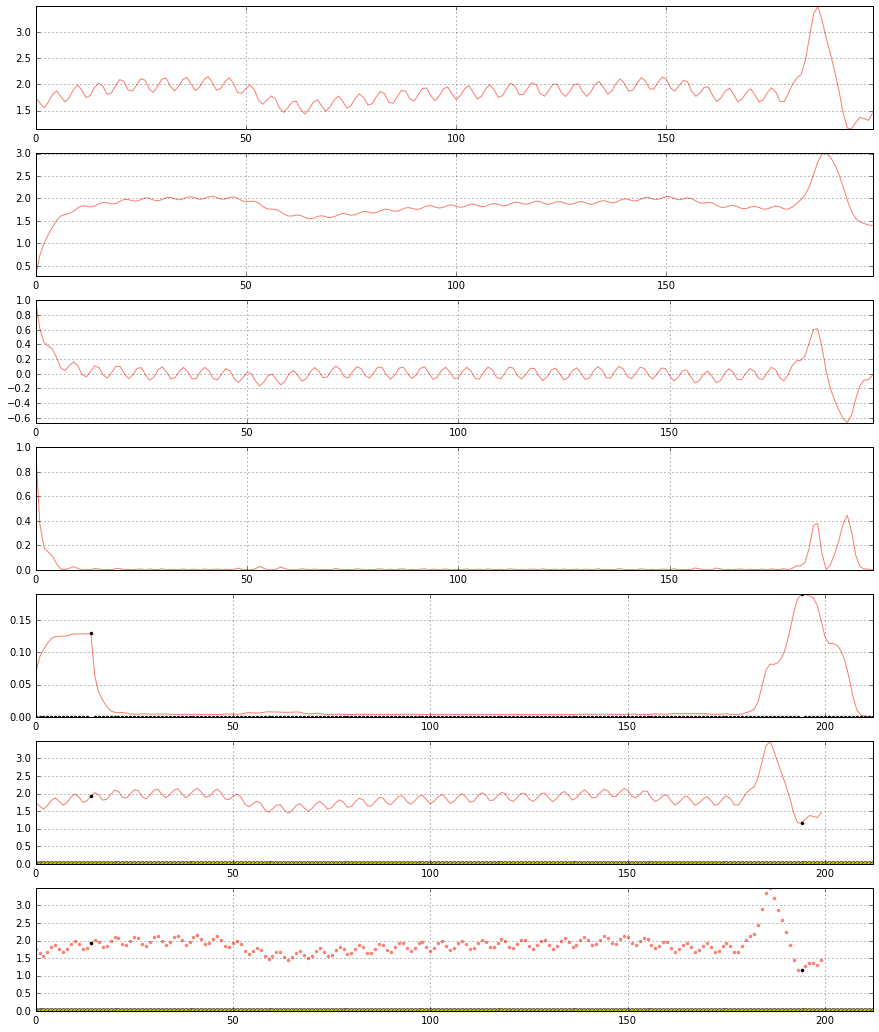

In [5]:
qrs_detector = QRSDetector("logs250hz/11.txt")
qrs_detector.load_data()
qrs_detector.process_data()
qrs_detector.threshold_peaks()
qrs_detector.plot_everything()

In [44]:
class QRSDetector():
    """QRS complex detector."""

    def __init__(self, file):
        """Variables initialization."""
        ## Data file path.
        self.file = file
        
        ## Signal processing variables.
        self.logged_beats = np.array([])
        self.raw_signal = np.array([])
        self.filtered = np.array([])
        self.differentiated_signal = np.array([])
        self.squared_signal = np.array([])
        self.integrated_signal = np.array([])

        # Peak detection variables.
        self.fiducial_mark_val_i = np.array([])
        self.fiducial_mark_idx = np.array([])

        ## Peak thresholding variables.
        self.qrs_peak_i = np.array([])
        self.noise_peak_i = np.array([])
        
        ## Integrated signal detection and thresholding params.
        self.spk_i = 0.0 
        self.npk_i = 0.0 
        self.threshold_i_1 = 0.0
        self.threshold_i_2 = 0.0 

        ## Params.
        self.signal_freq = 255
        self.filter_lowcut = 0.0
        self.filter_highcut = 15.0
        self.integration_window = 15
        
    ## Tool methods.
    def butter_bandpass_filter(self, data, lowcut, highcut, signal_freq, order):
        """Constructs signal filter."""
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(order, [low, high], btype='band')
        y = lfilter(b, a, data)
        return y
    
    ## Data processing methods.
    def load_data(self):
        """Loads and cleans data."""
        with open(self.file) as f:
            content = f.readlines()
        content = content[1:]
        for line in content:
            log = line.rstrip().split(' ')
            self.raw_signal = np.append(self.raw_signal, float(line.rstrip().split(' ')[2]))
#             self.logged_beats = np.append(self.logged_beats, float(line.rstrip().split(' ')[3]))
        self.raw_signal = [1.7546432018, 1.6471162796, 1.5542521476, 1.6617790222, 1.8035190582, 1.8768328666, 1.7693059444, 1.666666603, 1.7497556209, 1.901270771, 1.989247322, 1.8914956092, 1.7497556209, 1.7888562679, 1.9403715133, 2.0234603881, 1.9648094177, 1.8132943153, 1.8328446388, 1.9745845794, 2.0918865203, 2.0576734542, 1.8963831901, 1.8719452857, 1.9843597412, 2.106549263, 2.0821113586, 1.9110459327, 1.8475073814, 1.9599218368, 2.0967741012, 2.1212120056, 1.9745845794, 1.8768328666, 1.9648094177, 2.0918865203, 2.1358749866, 2.0039100646, 1.8817204475, 1.9550342559, 2.0869989395, 2.1505377292, 2.0381231307, 1.8914956092, 1.9208210945, 2.0478982925, 2.1260998249, 2.028347969, 1.8475073814, 1.8279570579, 1.9208210945, 1.989247322, 1.901270771, 1.7008798122, 1.6226783752, 1.7008798122, 1.7790811061, 1.7302052974, 1.5493645668, 1.4662756919, 1.5591397285, 1.666666603, 1.6813293457, 1.5298142433, 1.4369501113, 1.5249266624, 1.6568914413, 1.7106549739, 1.59335289, 1.4907135963, 1.5689149856, 1.7057673931, 1.7790811061, 1.6813293457, 1.5493645668, 1.5982404708, 1.7350928783, 1.8181818962, 1.7497556209, 1.6080156326, 1.6324535369, 1.7644183635, 1.8670577049, 1.8181818962, 1.6568914413, 1.6422286987, 1.7693059444, 1.8866080284, 1.8719452857, 1.7253177165, 1.6813293457, 1.8035190582, 1.9257086753, 1.9305962562, 1.7790811061, 1.6911046504, 1.783968687, 1.9159335136, 1.9501466751, 1.8181818962, 1.7106549739, 1.7888562679, 1.9159335136, 1.9745845794, 1.8523949623, 1.7204301357, 1.7741935253, 1.9159335136, 1.9941349029, 1.901270771, 1.7546432018, 1.783968687, 1.9208210945, 2.0234603881, 1.9648094177, 1.8035190582, 1.8132943153, 1.9257086753, 2.0332355499, 1.9941349029, 1.823069477, 1.7741935253, 1.8866080284, 2.0039100646, 2.0039100646, 1.8475073814, 1.7693059444, 1.8670577049, 1.9941349029, 2.0136852264, 1.8719452857, 1.7693059444, 1.8572825431, 1.9990224838, 2.0576734542, 1.9452590942, 1.8132943153, 1.8768328666, 2.0185728073, 2.106549263, 2.0136852264, 1.8719452857, 1.8914956092, 2.028347969, 2.1260998249, 2.067448616, 1.9159335136, 1.9110459327, 2.0430107116, 2.1407625675, 2.0967741012, 1.9257086753, 1.8719452857, 1.9794721603, 2.0772237777, 2.0527858734, 1.8670577049, 1.7741935253, 1.8377322196, 1.9501466751, 1.9452590942, 1.783968687, 1.6715541839, 1.7497556209, 1.8768328666, 1.9305962562, 1.8035190582, 1.666666603, 1.7253177165, 1.8426198005, 1.9159335136, 1.808406639, 1.666666603, 1.7057673931, 1.8475073814, 1.9354838371, 1.8523949623, 1.6764417648, 1.6715541839, 1.8328446388, 2.0136852264, 2.1212120056, 2.1896383762, 2.4535679817, 2.9081134796, 3.3528835773, 3.4848484992, 3.2160313129, 2.8739002227, 2.5708699226, 2.2434017658, 1.8817204475, 1.4565005302, 1.1681329011, 1.1534701585, 1.2756597995, 1.3734115362, 1.3489736318, 1.3147605657, 1.4565005302] 
        
    def process_data(self):
        """Process received data."""
        ## Signal filtering - pass band 0-15 Hz.
        self.filtered_signal = self.butter_bandpass_filter(self.raw_signal, lowcut=self.filter_lowcut, 
                                                           highcut=self.filter_highcut, signal_freq=self.signal_freq, order=1)
        
        ## Derivative - provides QRS slope info.
        self.differentiated_signal = np.ediff1d(self.filtered_signal) 

        ## Squaring.
        self.squared_signal = self.differentiated_signal**2
        
        ## Moving-window integration.
        self.integrated_signal = np.convolve(self.squared_signal, np.ones(self.integration_window))

        ## Fiducial mark - peak detection - integrated signal - janko_slavic algorithm
        # Small and fast peak detection algorithm, with minimum distance and height filtering support. Comes as an handy single function, depending only on Numpy.
        # Contrary to the MatLab findpeaks-like distance filters, the Janko Slavic findpeaks spacing param requires that all points within the specified width to be lower than the peak. If you work on very low sampled signal the minimum distance filter may miss fine granularity tuning .
        # https://github.com/jankoslavic/py-tools/blob/master/findpeaks/Findpeaks%20example.ipynb
        # https://github.com/MonsieurV/py-findpeaks#janko-slavic-findpeaks
        self.peaks_indices = findpeaks(self.integrated_signal, limit=0.30, spacing=50)

        for peak_index in self.peaks_indices:
            self.fiducial_mark_idx = np.append(self.fiducial_mark_idx, peak_index)
            self.fiducial_mark_val_i = np.append(self.fiducial_mark_val_i, self.integrated_signal[peak_index])
    
    def threshold_peaks(self):
        """Thresholding detect peaks - integrated signal."""
        for peak_idx, peak_val_i in zip(self.fiducial_mark_idx, self.fiducial_mark_val_i):
            if peak_val_i > self.threshold_i_1:
                self.spk_i = 0.125 * peak_val_i + 0.875 * self.spk_i
                self.qrs_peak_i = np.append(self.qrs_peak_i, peak_idx)
            else:
                self.npk_i = 0.125 * peak_val_i + 0.875 * self.npk_i
                self.noise_peak_i = np.append(self.noise_peak_i, peak_idx)

            self.threshold_i_1 = self.npk_i + 0.25 * (self.spk_i - self.npk_i)
            self.threshold_i_2 = 0.5 * self.threshold_i_1 
        
    ## Visualization methods.
    def plot_everything(self):
        ## Plot everything.
        plt.figure(figsize=(15,18))
        plt.subplot(711)
        plt.plot(self.raw_signal, label="Original signal", color="salmon")
        plt.plot(self.logged_beats, label="Original signal", color="grey")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(712)
        plt.plot(self.filtered_signal, label="Filtered signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(713)
        plt.plot(self.differentiated_signal, label="Differentiated signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(714)
        plt.plot(self.squared_signal, label="Squared signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        fiducial_mark_indication_i = [0] * len(self.integrated_signal)
        for peak_idx_i, peak_val_i in zip(self.fiducial_mark_idx, self.fiducial_mark_val_i):
            fiducial_mark_indication_i[int(peak_idx_i)] = peak_val_i
        plt.subplot(715)
        plt.plot(self.integrated_signal, label="Integrated signal", color="salmon")
        plt.plot(fiducial_mark_indication_i, 'k.')
        plt.plot(self.logged_beats / 3.0, label="Original signal", color="grey")
        plt.grid(True)
        plt.axis("tight")
        
        qrs_peak_indication_i = [0] * len(self.integrated_signal)
        for peak_i in self.qrs_peak_i:
            qrs_peak_indication_i[int(peak_i)] = self.raw_signal[int(peak_i)]
        noise_peak_indication_i = [0] * len(self.integrated_signal)
        for peak_i in self.noise_peak_i:
            noise_peak_indication_i[int(peak_i)] = self.raw_signal[int(peak_i)]
            
        plt.subplot(716)
        plt.plot(self.raw_signal, label="Integrated signal", color="salmon")
        plt.plot(qrs_peak_indication_i, 'k.')
        plt.plot(noise_peak_indication_i, 'yo')
        plt.plot(self.logged_beats, label="Original signal", color="grey")
        plt.grid(True)
        plt.axis("tight")
        
        plt.subplot(717)
        plt.plot(self.raw_signal, 'k.', label="Integrated signal", color="salmon")
        plt.plot(qrs_peak_indication_i, 'k.')
        plt.plot(noise_peak_indication_i, 'yo')
        plt.grid(True)
        plt.axis("tight")

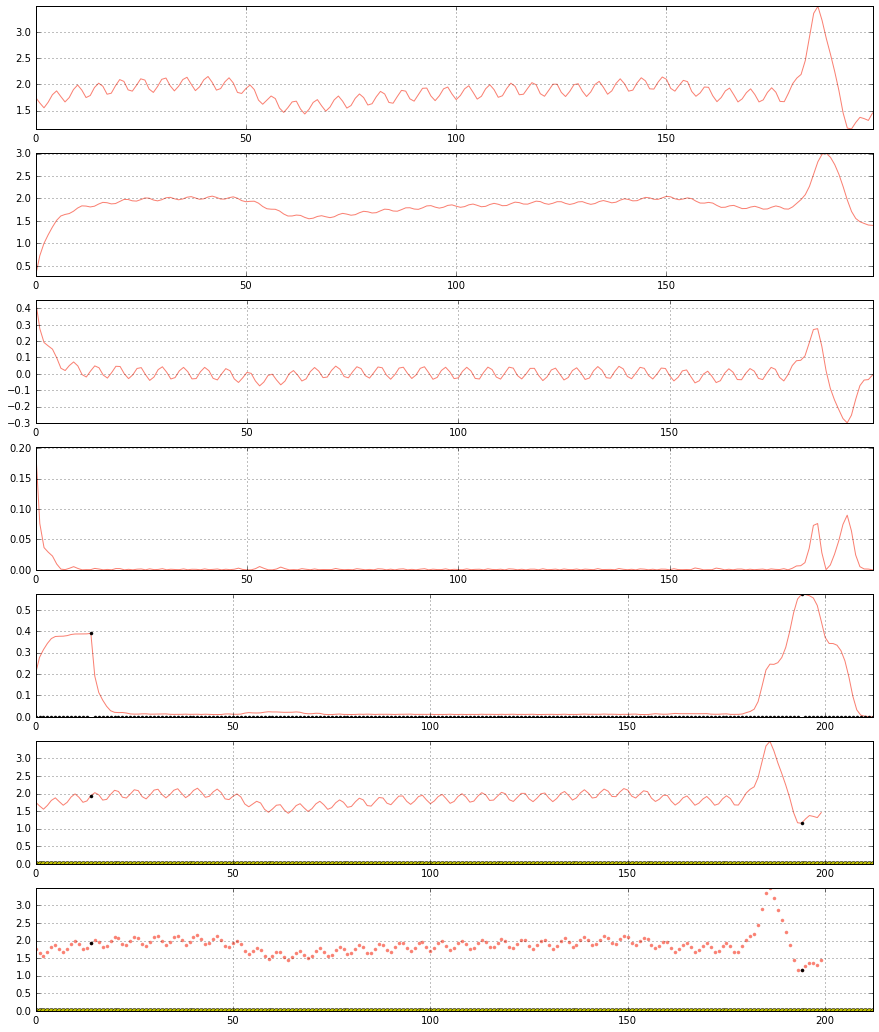

In [45]:
qrs_detector = QRSDetector("logs250hz/11.txt")
qrs_detector.load_data()
qrs_detector.process_data()
qrs_detector.threshold_peaks()
qrs_detector.plot_everything()

In [8]:
class QRSDetector():
    """QRS complex detector."""

    def __init__(self, file):
        """Variables initialization."""
        ## Data file path.
        self.file = file
        
        ## Signal processing variables.
        self.logged_beats = np.array([])
        self.raw_signal = np.array([])
        self.filtered = np.array([])
        self.differentiated_signal = np.array([])
        self.squared_signal = np.array([])
        self.integrated_signal = np.array([])

        # Peak detection variables.
        self.fiducial_mark_val_i = np.array([])
        self.fiducial_mark_idx = np.array([])

        ## Peak thresholding variables.
        self.qrs_peak_i = np.array([])
        self.noise_peak_i = np.array([])
        
        ## Integrated signal detection and thresholding params.
        self.spk_i = 0.0 
        self.npk_i = 0.0 
        self.threshold_i_1 = 0.0
        self.threshold_i_2 = 0.0 

        ## Params.
        self.signal_freq = 255
        self.filter_lowcut = 0.0
        self.filter_highcut = 15.0
        self.integration_window = 15
        
    ## Tool methods.
    def butter_bandpass_filter(self, data, lowcut, highcut, signal_freq, order):
        """Constructs signal filter."""
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(order, [low, high], btype='band')
        y = lfilter(b, a, data)
        return y
    
    ## Data processing methods.
    def load_data(self):
        """Loads and cleans data."""
        with open(self.file) as f:
            content = f.readlines()
        content = content[1:]
        for line in content:
            log = line.rstrip().split(' ')
            self.raw_signal = np.append(self.raw_signal, float(line.rstrip().split(' ')[2]))
            self.logged_beats = np.append(self.logged_beats, float(line.rstrip().split(' ')[3]))

    def process_data(self):
        """Process received data."""
        ## Signal filtering - pass band 0-15 Hz.
        self.filtered_signal = self.butter_bandpass_filter(self.raw_signal, lowcut=self.filter_lowcut, 
                                                           highcut=self.filter_highcut, signal_freq=self.signal_freq, order=1)
        
        ## Derivative - provides QRS slope info.
        self.differentiated_signal = np.ediff1d(self.filtered_signal) 

        ## Squaring.
        self.squared_signal = self.differentiated_signal**2
        
        ## Moving-window integration.
        self.integrated_signal = np.convolve(self.squared_signal, np.ones(self.integration_window))

        ## Fiducial mark - peak detection - integrated signal - janko_slavic algorithm
        # Small and fast peak detection algorithm, with minimum distance and height filtering support. Comes as an handy single function, depending only on Numpy.
        # Contrary to the MatLab findpeaks-like distance filters, the Janko Slavic findpeaks spacing param requires that all points within the specified width to be lower than the peak. If you work on very low sampled signal the minimum distance filter may miss fine granularity tuning .
        # https://github.com/jankoslavic/py-tools/blob/master/findpeaks/Findpeaks%20example.ipynb
        # https://github.com/MonsieurV/py-findpeaks#janko-slavic-findpeaks
        self.peaks_indices = findpeaks(self.integrated_signal, limit=0.30, spacing=50)

        for peak_index in self.peaks_indices:
            self.fiducial_mark_idx = np.append(self.fiducial_mark_idx, peak_index)
            self.fiducial_mark_val_i = np.append(self.fiducial_mark_val_i, self.integrated_signal[peak_index])
    
    def threshold_peaks(self):
        """Thresholding detect peaks - integrated signal."""
        for peak_idx, peak_val_i in zip(self.fiducial_mark_idx, self.fiducial_mark_val_i):
            if peak_val_i > self.threshold_i_1:
                self.spk_i = 0.125 * peak_val_i + 0.875 * self.spk_i
                self.qrs_peak_i = np.append(self.qrs_peak_i, peak_idx)
            else:
                self.npk_i = 0.125 * peak_val_i + 0.875 * self.npk_i
                self.noise_peak_i = np.append(self.noise_peak_i, peak_idx)

            self.threshold_i_1 = self.npk_i + 0.25 * (self.spk_i - self.npk_i)
            self.threshold_i_2 = 0.5 * self.threshold_i_1 
        
    ## Visualization methods.
    def plot_everything(self):
        ## Plot everything.
        plt.figure(figsize=(15,18))
        plt.subplot(711)
        plt.plot(self.raw_signal, label="Original signal", color="salmon")
        plt.plot(self.logged_beats, label="Original signal", color="grey")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(712)
        plt.plot(self.filtered_signal, label="Filtered signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(713)
        plt.plot(self.differentiated_signal, label="Differentiated signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(714)
        plt.plot(self.squared_signal, label="Squared signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        fiducial_mark_indication_i = [0] * len(self.integrated_signal)
        for peak_idx_i, peak_val_i in zip(self.fiducial_mark_idx, self.fiducial_mark_val_i):
            fiducial_mark_indication_i[int(peak_idx_i)] = peak_val_i
        plt.subplot(715)
        plt.plot(self.integrated_signal, label="Integrated signal", color="salmon")
        plt.plot(fiducial_mark_indication_i, 'k.')
        plt.plot(self.logged_beats / 3.0, label="Original signal", color="grey")
        plt.grid(True)
        plt.axis("tight")
        
        qrs_peak_indication_i = [0] * len(self.integrated_signal)
        for peak_i in self.qrs_peak_i:
            qrs_peak_indication_i[int(peak_i)] = self.raw_signal[int(peak_i)]
        noise_peak_indication_i = [0] * len(self.integrated_signal)
        for peak_i in self.noise_peak_i:
            noise_peak_indication_i[int(peak_i)] = self.raw_signal[int(peak_i)]
            
        plt.subplot(716)
        plt.plot(self.raw_signal, label="Integrated signal", color="salmon")
        plt.plot(qrs_peak_indication_i, 'k.')
        plt.plot(noise_peak_indication_i, 'yo')
        plt.plot(self.logged_beats, label="Original signal", color="grey")
        plt.grid(True)
        plt.axis("tight")
        
        plt.subplot(717)
        plt.plot(self.raw_signal, 'k.', label="Integrated signal", color="salmon")
        plt.plot(qrs_peak_indication_i, 'k.')
        plt.plot(noise_peak_indication_i, 'yo')
        plt.grid(True)
        plt.axis("tight")

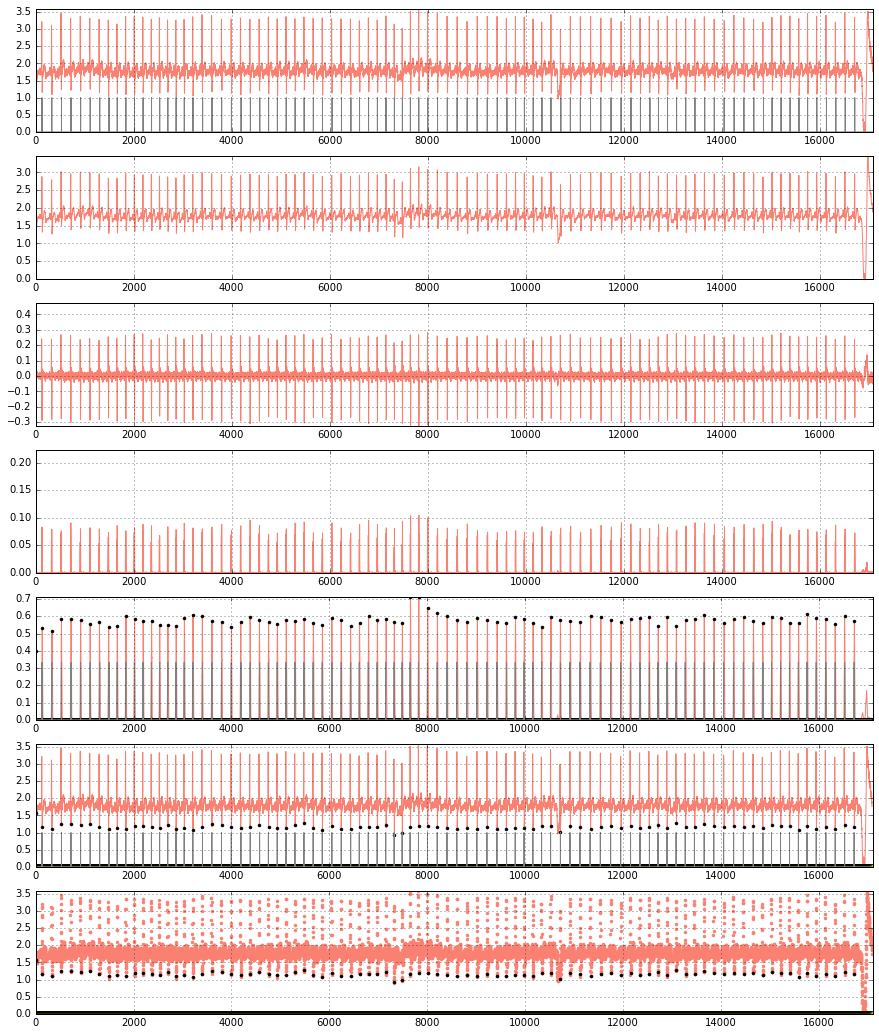

In [10]:
qrs_detector = QRSDetector("logs250hz/21.txt")
qrs_detector.load_data()
qrs_detector.process_data()
qrs_detector.threshold_peaks()
qrs_detector.plot_everything()